## Import + options d'affichage

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text


pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

## Charger CSV + aperçu brut

In [3]:
df_raw = pd.read_csv("results/summary_refine_filtered_with_pocket_props.csv")

print("Shape brute:", df_raw.shape)
display(df_raw.head(10))

Shape brute: (65, 27)


,status,protein,ligand,type,tag,best_affinity_kcal_mol,min_rmsd_lb_modes2plus,results_dir,pymol_open,lig_cyclic,lig_len_aa,lig_polarity_0_1,lig_flex_0_1,lig_charge_ph74,lig_charge_kind,lig_formal_charge,lig_mw,lig_tpsa,lig_rot_bonds,lig_ring_count,pocket_residues_n,hydrophobic_pct,polar_pct,pos_count,neg_count,net_charge,hbond_count
0,SKIP,ppp5c_moule.pdb,aeruginosin98A_2D.sdf,enzyme,ppp5c_moule__aeruginosin98A,-9.781,1.623,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,lineaire,4,1.0,0.833,0,formal_charge_rdkit,0,689.23,246.97,20,3,62,32.3,40.3,9,8,1,244
1,SKIP,ace_daphnia.pdb,microgininFR1_2D.sdf,enzyme,ace_daphnia__microgininFR1,-8.853,1.194,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,lineaire,5,1.0,0.912,0,formal_charge_rdkit,0,727.90,231.62,31,2,45,26.7,46.7,5,7,-2,169
2,SKIP,slco1c1_zebrafish.pdb,aeruginosin98A_2D.sdf,transporteur,slco1c1_zebrafish__aeruginosin98A,-8.597,2.081,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,lineaire,4,1.0,0.833,0,formal_charge_rdkit,0,689.23,246.97,20,3,47,48.9,34.0,5,3,2,143
3,SKIP,slco1c1_xenope.pdb,aeruginosin98A_2D.sdf,transporteur,slco1c1_xenope__aeruginosin98A,-8.585,1.493,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,lineaire,4,1.0,0.833,0,formal_charge_rdkit,0,689.23,246.97,20,3,48,50.0,33.3,5,3,2,143
4,SKIP,slco1c1_xenope.pdb,microcystineLR_2D.sdf,transporteur,slco1c1_xenope__microcystineLR,-8.416,1.630,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,cyclique,8,1.0,0.889,0,formal_charge_rdkit,0,995.19,343.14,24,2,59,54.2,32.2,5,3,2,204
5,SKIP,cftr_zebrafish.pdb,microcystineLR_2D.sdf,transporteur,cftr_zebrafish__microcystineLR,-8.325,1.767,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,cyclique,8,1.0,0.889,0,formal_charge_rdkit,0,995.19,343.14,24,2,76,36.8,28.9,14,12,2,276
6,SKIP,cftr_zebrafish.pdb,aeruginosin98A_2D.sdf,transporteur,cftr_zebrafish__aeruginosin98A,-8.315,2.497,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,lineaire,4,1.0,0.833,0,formal_charge_rdkit,0,689.23,246.97,20,3,68,35.3,32.4,13,9,4,204
7,SKIP,ppp5c_moule.pdb,microgininFR1_2D.sdf,enzyme,ppp5c_moule__microgininFR1,-8.297,1.465,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,lineaire,5,1.0,0.912,0,formal_charge_rdkit,0,727.90,231.62,31,2,56,32.1,41.1,8,7,1,185
8,SKIP,ace_daphnia.pdb,microcystineLR_2D.sdf,enzyme,ace_daphnia__microcystineLR,-8.279,1.529,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,cyclique,8,1.0,0.889,0,formal_charge_rdkit,0,995.19,343.14,24,2,53,37.7,39.6,5,7,-2,224
9,SKIP,abcg2_xenope.pdb,aeruginosin98A_2D.sdf,transporteur,abcg2_xenope__aeruginosin98A,-8.208,1.105,/Users/user/Desktop/Projet_long/docking/result...,pymol /Users/user/Desktop/Projet_long/docking/...,lineaire,4,1.0,0.833,0,formal_charge_rdkit,0,689.23,246.97,20,3,63,38.1,30.2,11,9,2,197


## Nettoyage protein / ligand + ajout colonne organisme

In [58]:
def split_protein_and_organism(s):
    """
    Exemple : "ppp5c_moule.pdb" -> protein="ppp5c", organisme="moule"
    """
    if not isinstance(s, str):
        return s, None

    stem = Path(s).stem
    parts = stem.split("_", 1)

    protein = parts[0]
    organism = parts[1] if len(parts) > 1 else None

    return protein, organism


def clean_ligand(s):
    """
    - "microcystineLR_2D.sdf" -> "microcystineLR"
    - "microcyclamide7806B_3D.sdf" -> "microcyclamide7806B"
    """
    if not isinstance(s, str):
        return s
    stem = Path(s).stem
    return stem.replace("_2D", "").replace("_3D", "")

# =====================
# APPLY CLEANING
# =====================

df = df_raw.copy()

# split protein / organism
df[["protein", "organisme"]] = df["protein"].apply(
    lambda x: pd.Series(split_protein_and_organism(x))
)

# clean ligand
df["ligand"] = df["ligand"].apply(clean_ligand)

# rename key quantitative columns
df = df.rename(columns={
    "best_affinity_kcal_mol": "best_affinity",
    "min_rmsd_lb_modes2plus": "min_rmsd_lb",
})

# =====================
# DROP USELESS / UNRELIABLE COLUMNS
# =====================
DROP_COLS = [
    "status",
    "results_dir",
    "pymol_open",
    "tag",
    "lig_charge_ph74",
    "lig_charge_kind",
    "lig_formal_charge",
]

df = df.drop(columns=DROP_COLS, errors="ignore")

# =====================
# RENAME COLUMNS (CLARITY)
# =====================

df = df.rename(columns={

    # Docking
    "best_affinity": "affinité",
    "min_rmsd_lb": "rmsd",

    # Ligand properties
    "lig_cyclic": "lig_topologie",
    "lig_len_aa": "lig_taille",
    "lig_mw": "lig_masse", # a supprimer
    "lig_tpsa": "lig_polarité",
    "lig_rot_bonds": "lig_flexible",  # a supprimer
    "lig_ring_count": "lig_nb_cycle", # a supprimer
    "lig_flex_0_1": "ligand_flexibilité", 
    "lig_polarity_0_1": "ligand_polarité",  # a supprimer

    # Pocket properties
    "pocket_residues_n": "poche_taille",
    "hydrophobic_pct": "poche_hydrophobe",
    "polar_pct": "poche_polarité", # a supprimer
    "pos_count": "pocket_pos_residues", # a supprimer
    "neg_count": "pocket_neg_residues", # a supprimer
    "net_charge": "poche_charge",
})

# =====================
# DROP REDUNDANT COLUMNS
# =====================

DROP_COLS_FINAL = [
    # Ligand
    "lig_masse",
    "lig_flexible",
    "ligand_polarité",
    "lig_nb_cycle",

    # Pocket
    "poche_polarité",
    "pocket_pos_residues",
    "pocket_neg_residues",
]

df = df.drop(columns=DROP_COLS_FINAL, errors="ignore")

df["affinité_inv"] = -df["affinité"]

# =====================
# CHECK
# =====================
print("Shape après nettoyage:", df.shape)
display(df.head(10))

Shape après nettoyage: (65, 15)


,protein,ligand,type,affinité,rmsd,lig_topologie,lig_taille,ligand_flexibilité,lig_polarité,poche_taille,poche_hydrophobe,poche_charge,hbond_count,organisme,affinité_inv
0,ppp5c,aeruginosin98A,enzyme,-9.781,1.623,lineaire,4,0.833,246.97,62,32.3,1,244,moule,9.781
1,ace,microgininFR1,enzyme,-8.853,1.194,lineaire,5,0.912,231.62,45,26.7,-2,169,daphnia,8.853
2,slco1c1,aeruginosin98A,transporteur,-8.597,2.081,lineaire,4,0.833,246.97,47,48.9,2,143,zebrafish,8.597
3,slco1c1,aeruginosin98A,transporteur,-8.585,1.493,lineaire,4,0.833,246.97,48,50.0,2,143,xenope,8.585
4,slco1c1,microcystineLR,transporteur,-8.416,1.630,cyclique,8,0.889,343.14,59,54.2,2,204,xenope,8.416
5,cftr,microcystineLR,transporteur,-8.325,1.767,cyclique,8,0.889,343.14,76,36.8,2,276,zebrafish,8.325
6,cftr,aeruginosin98A,transporteur,-8.315,2.497,lineaire,4,0.833,246.97,68,35.3,4,204,zebrafish,8.315
7,ppp5c,microgininFR1,enzyme,-8.297,1.465,lineaire,5,0.912,231.62,56,32.1,1,185,moule,8.297
8,ace,microcystineLR,enzyme,-8.279,1.529,cyclique,8,0.889,343.14,53,37.7,-2,224,daphnia,8.279
9,abcg2,aeruginosin98A,transporteur,-8.208,1.105,lineaire,4,0.833,246.97,63,38.1,2,197,xenope,8.208


In [74]:
df["poche_charge"].mean().round(2)

1.25

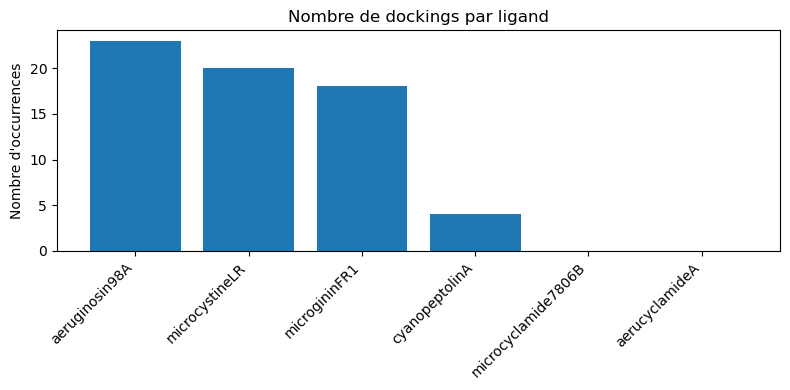

In [10]:
import matplotlib.pyplot as plt

# 1) choisis tes 5 ligands "cibles" (exemple)
ligands_cibles = [
    "aeruginosin98A",
    "microcystineLR",
    "microgininFR1",
    "cyanopeptolinA",
    "microcyclamide7806B",
    "aerucyclamideA"
]

# 2) compter et forcer les 0
counts = (
    df["ligand"]
    .value_counts()
    .reindex(ligands_cibles, fill_value=0)
)

# 3) plot
plt.figure(figsize=(8, 4))
plt.bar(counts.index, counts.values)
plt.ylabel("Nombre d'occurrences")
plt.title("Nombre de dockings par ligand")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [19]:
print(df["poche_hydrophobe"].mean())
print(df["poche_hydrophobe"].max())
print(df["poche_hydrophobe"].min())

38.644615384615385
56.5
21.4


,ligand,p_raw,p_adj,signif
2,microgininFR1,0.013072,0.039216,*


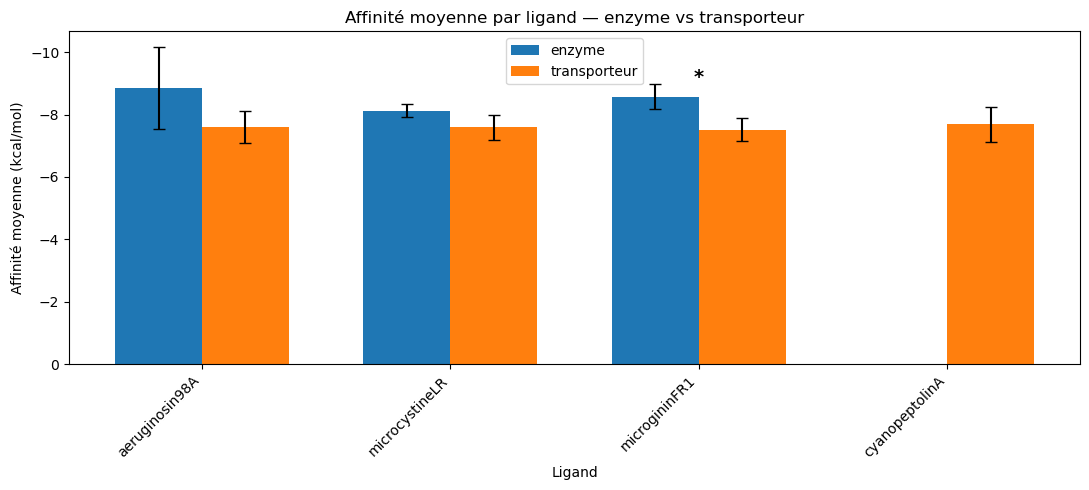

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# =====================
# UTILS
# =====================
def p_to_stars(p):
    if pd.isna(p): return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

# =====================
# 0) LIGANDS À AFFICHER (force l'affichage même si un type manque)
# =====================
ligands = [
    "aeruginosin98A",
    "microcystineLR",
    "microgininFR1",
    "cyanopeptolinA"
]

df = df.copy()
df["ligand"] = df["ligand"].astype(str).str.strip()

# =====================
# 1) SUMMARY mean±std (ligand x type) — sans filtrage
# =====================
summary = (
    df.groupby(["ligand", "type"], as_index=False)
      .agg(mean=("affinité", "mean"),
           std=("affinité", "std"),
           n=("affinité", "count"))
)

# =====================
# 2) STATS : enzyme vs transporteur par ligand (seulement si n>=2 dans les deux)
# =====================
rows = []
for ligand in ligands:
    sub = df[df["ligand"] == ligand]
    enz = sub[sub["type"] == "enzyme"]["affinité"].dropna()
    tra = sub[sub["type"] == "transporteur"]["affinité"].dropna()

    # si un type manque ou n<2 -> pas de test, mais le ligand reste affiché
    if len(enz) >= 2 and len(tra) >= 2:
        p = mannwhitneyu(enz, tra, alternative="two-sided").pvalue
        rows.append({"ligand": ligand, "p_raw": p})

stats_df = pd.DataFrame(rows)

if not stats_df.empty:
    stats_df["p_adj"] = multipletests(stats_df["p_raw"], method="fdr_bh")[1]
    stats_df["signif"] = stats_df["p_adj"].apply(p_to_stars)
else:
    stats_df = pd.DataFrame(columns=["ligand", "p_adj", "signif"])

# tableau significatif uniquement (pas de "ns")
sig_table = stats_df[stats_df["signif"] != ""].sort_values("p_adj")
display(sig_table)

# =====================
# 3) FIGURE : barplot enzyme vs transporteur + étoiles si test possible
# =====================
x = np.arange(len(ligands))
width = 0.35

plt.figure(figsize=(11, 5))

for i, t in enumerate(["enzyme", "transporteur"]):
    sub = (
        summary[summary["type"] == t]
        .set_index("ligand")
        .reindex(ligands)   # ✅ force l’ordre + garde les absents
    )

    plt.bar(
        x + (i - 0.5) * width,
        sub["mean"],
        width,
        yerr=sub["std"],
        capsize=4,
        label=t
    )

# ⭐ étoiles (uniquement si test présent)
for i, ligand in enumerate(ligands):
    r = stats_df[stats_df["ligand"] == ligand]
    if not r.empty and r["signif"].iloc[0] != "":
        # placer l’étoile un peu au-dessus de la meilleure (plus négative) des deux barres
        means = summary[(summary["ligand"] == ligand)]["mean"].dropna()
        if len(means) > 0:
            y = means.min() - 0.3
            plt.text(i, y, r["signif"].iloc[0],
                     ha="center", va="bottom",
                     fontsize=14, fontweight="bold")

plt.xticks(x, ligands, rotation=45, ha="right")
plt.ylabel("Affinité moyenne (kcal/mol)")
plt.xlabel("Ligand")
plt.title("Affinité moyenne par ligand — enzyme vs transporteur")
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

Variance expliquée :
PC1 : 31.9 %
PC2 : 18.3 %


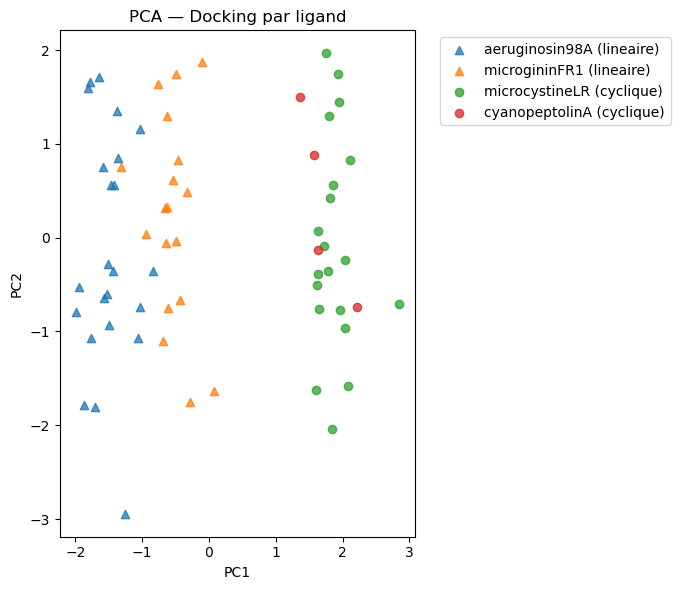

,PC1,PC2
lig_taille,0.655665,0.021283
lig_polarité,0.609308,-0.022473
ligand_flexibilité,0.327732,0.097454
poche_taille,0.287684,0.052909
affinité_inv,-0.063959,0.567314
poche_charge,-0.057794,0.556537
poche_hydrophobe,0.035285,0.595958


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =====================
# PCA FEATURES
# =====================
pca_features = [
    "affinité_inv",
    "lig_taille",
    "ligand_flexibilité",
    "lig_polarité",
    "poche_taille",
    "poche_hydrophobe",
    "poche_charge",
]

# =====================
# PREP DATA
# =====================
X = df[pca_features].dropna().copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

df_pca = df.loc[X.index].copy()
df_pca["PC1"] = X_pca[:, 0]
df_pca["PC2"] = X_pca[:, 1]

print("Variance expliquée :")
print("PC1 :", round(pca.explained_variance_ratio_[0]*100, 1), "%")
print("PC2 :", round(pca.explained_variance_ratio_[1]*100, 1), "%")

# =====================
# MARKERS PAR TOPOLOGIE
# =====================
marker_map = {
    "cyclique": "o",
    "lineaire": "^",
}

# =====================
# PLOT
# =====================
plt.figure(figsize=(7, 6))

for lig in df_pca["ligand"].unique():
    for topo, marker in marker_map.items():
        sub = df_pca[
            (df_pca["ligand"] == lig) &
            (df_pca["lig_topologie"] == topo)
        ]
        if len(sub) == 0:
            continue

        plt.scatter(
            sub["PC1"],
            sub["PC2"],
            label=f"{lig} ({topo})",
            marker=marker,
            alpha=0.75
        )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA — Docking par ligand")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# =====================
# LOADINGS
# =====================
loadings = pd.DataFrame(
    pca.components_.T,
    index=pca_features,
    columns=["PC1", "PC2"]
)

display(loadings.sort_values("PC1", key=abs, ascending=False))

Tout les docking d'un meme ligand se ressemblent, meme avec des proteines differentes. Les docking se regroupent pasr ligand, ce qui justifie une analyse comparative par ligand plutot que par proteine indiv

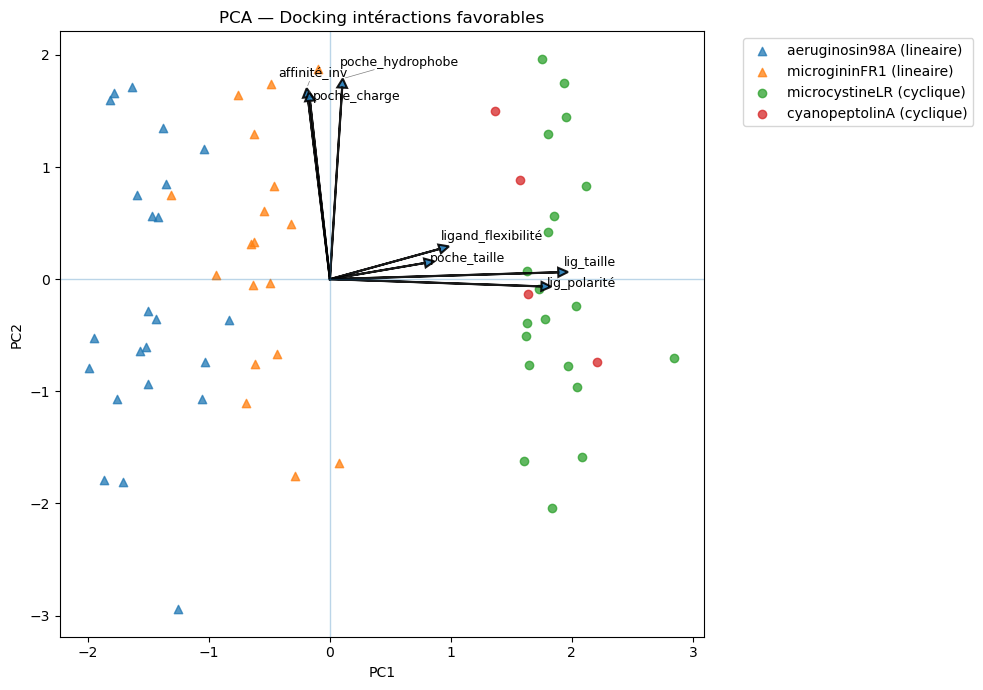

In [14]:
# =====================
# BIPLOT : points (couleur=ligand, forme=topologie) + flèches (loadings)
# =====================

plt.figure(figsize=(10, 7))  # au lieu de (8, 7)

# --- 1) Points ---
for lig in df_pca["ligand"].unique():
    for topo, marker in marker_map.items():
        sub = df_pca[
            (df_pca["ligand"] == lig) &
            (df_pca["lig_topologie"] == topo)
        ]
        if len(sub) == 0:
            continue

        plt.scatter(
            sub["PC1"],
            sub["PC2"],
            label=f"{lig} ({topo})",
            marker=marker,
            alpha=0.75
        )

# --- 2) Flèches (loadings) ---
arrow_scale = 3.0  # ajuste si trop grand/petit

texts = []

for var in loadings.index:
    x, y = loadings.loc[var, "PC1"], loadings.loc[var, "PC2"]
    if np.isfinite(x) and np.isfinite(y):
        plt.arrow(
            0, 0,
            x * arrow_scale, y * arrow_scale,
            head_width=0.08, head_length=0.08,
            length_includes_head=True,
            linewidth=1.5,
            alpha=0.9
        )
        texts.append(
            plt.text(
                x * arrow_scale,
                y * arrow_scale,
                var,
                fontsize=9
            )
        )

# 🔥 magie ici
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.5)
)

plt.axhline(0, linewidth=1, alpha=0.3)
plt.axvline(0, linewidth=1, alpha=0.3)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA — Docking intéractions favorables")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)
plt.tight_layout()
plt.show()

In [66]:
df.groupby("ligand")[[
    "affinité",
    "poche_taille",
    "poche_hydrophobe",
    "poche_charge",
    "lig_taille",
    "ligand_flexibilité",
    "lig_polarité",
]].mean().round(2)

,affinité,poche_taille,poche_hydrophobe,poche_charge,lig_taille,ligand_flexibilité,lig_polarité
ligand,,,,,,,
aeruginosin98A,-7.72,56.78,37.58,1.22,4.0,0.83,246.97
cyanopeptolinA,-7.69,68.25,42.00,2.00,8.0,0.87,334.35
microcystineLR,-7.65,62.00,38.12,0.75,8.0,0.89,343.14
microgininFR1,-7.64,55.22,39.84,1.67,5.0,0.91,231.62


In [70]:
idx = df.groupby("ligand")["affinité"].idxmin()

df.loc[idx, ["ligand", "protein", "affinité", "rmsd", "poche_charge", "poche_hydrophobe", "lig_polarité"]].sort_values("affinité")

,ligand,protein,affinité,rmsd,poche_charge,poche_hydrophobe,lig_polarité
0,aeruginosin98A,ppp5c,-9.781,1.623,1,32.3,246.97
1,microgininFR1,ace,-8.853,1.194,-2,26.7,231.62
4,microcystineLR,slco1c1,-8.416,1.630,2,54.2,343.14
10,cyanopeptolinA,cftr,-8.194,1.779,3,38.8,334.35


In [11]:
df.groupby("lig_topologie")[[
    "affinité",
    "poche_taille",
    "poche_hydrophobe",
    "poche_charge"
]].mean().round(2)

,affinité,poche_taille,poche_hydrophobe,poche_charge
lig_topologie,,,,
cyclique,-7.65,63.04,38.77,0.96
lineaire,-7.68,56.10,38.57,1.41


<Axes: xlabel='lig_topologie', ylabel='affinité'>

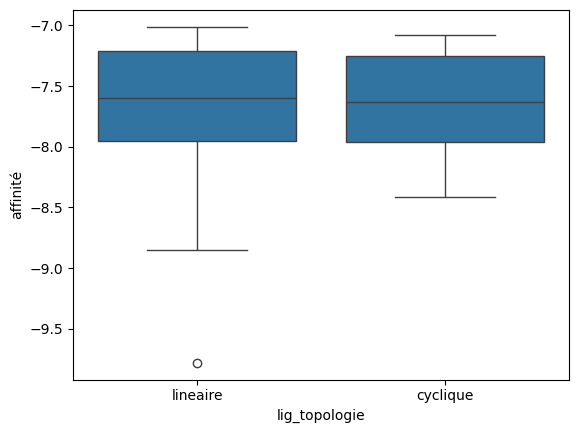

In [12]:
import seaborn as sns
sns.boxplot(data=df, x="lig_topologie", y="affinité")

In [13]:
df.groupby("type")[[
    "affinité",
    "poche_taille",
    "poche_hydrophobe",
    "poche_charge"
]].mean().round(2)

,affinité,poche_taille,poche_hydrophobe,poche_charge
type,,,,
enzyme,-8.52,58.67,37.47,0.00
transporteur,-7.59,58.66,38.76,1.37


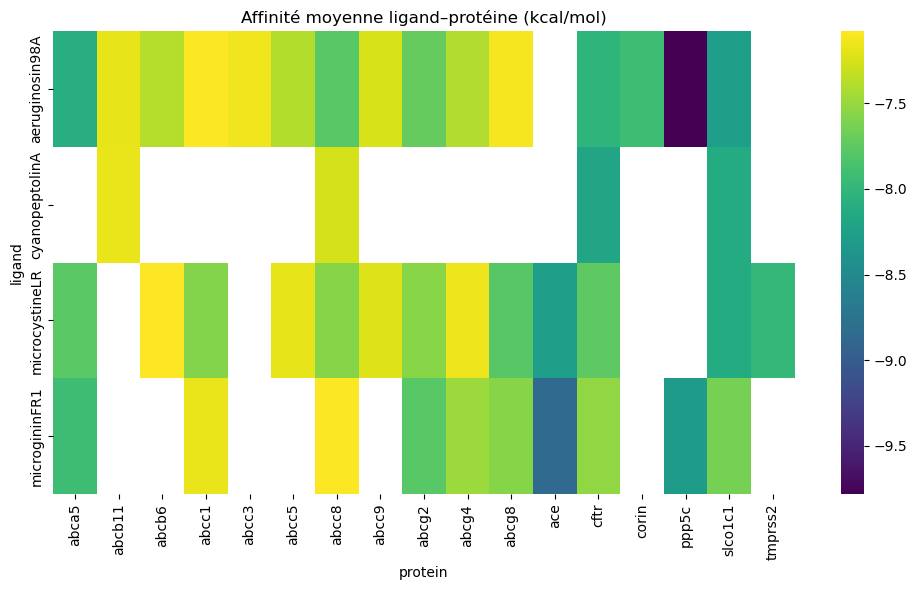

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    cmap="viridis",
    annot=False
)
plt.title("Affinité moyenne ligand–protéine (kcal/mol)")
plt.tight_layout()
plt.show()

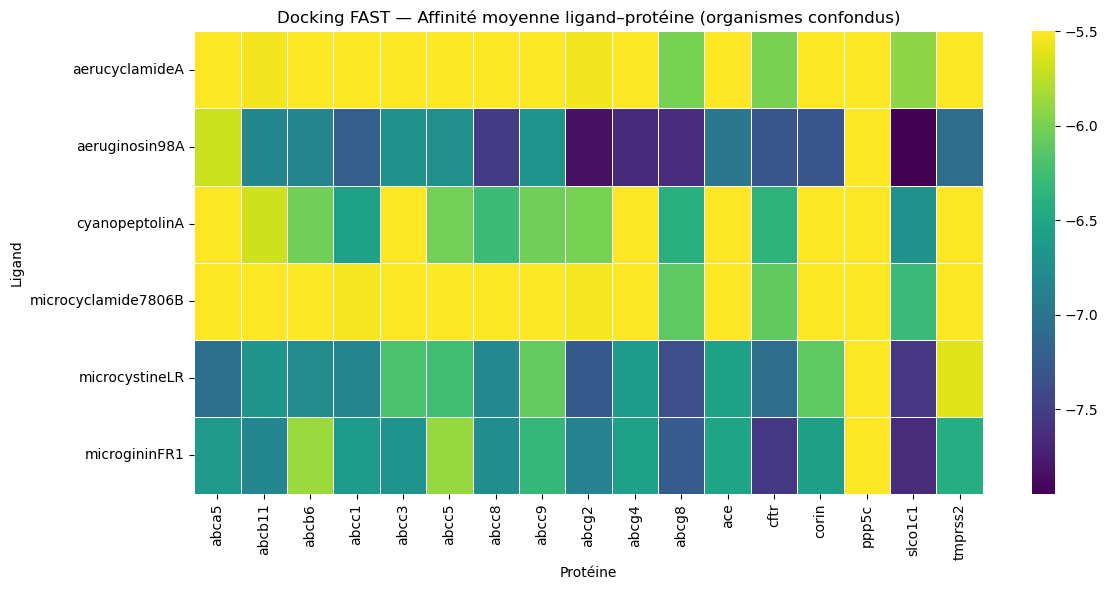

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_fast = pd.read_csv("results/summary_fast.csv")

# Nettoyage ligand
df_fast["ligand"] = (
    df_fast["ligand"]
    .astype(str)
    .str.replace(".sdf", "", regex=False)
    .str.replace("_2D", "", regex=False)
    .str.replace("_3D", "", regex=False)
)

# Nettoyage protéine (sans organisme)
df_fast["protein_clean"] = (
    df_fast["protein"]
    .astype(str)
    .str.lower()
    .str.replace(".pdb", "", regex=False)
    .str.split("_")
    .str[0]
)

# Pivot (moyenne sans valeurs positives)
pivot_protein = df_fast.pivot_table(
    index="ligand",
    columns="protein_clean",
    values="best_affinity_kcal_mol",
    aggfunc="mean"
)

vmin = pivot_protein.min().min()  # minimum global (ignore NaN automatiquement)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_protein,
    cmap="viridis",
    annot=False,
    linewidths=0.5,
    linecolor="white",
    vmin=vmin,
    vmax=-5.5
)

plt.title("Docking FAST — Affinité moyenne ligand–protéine (organismes confondus)")
plt.xlabel("Protéine")
plt.ylabel("Ligand")
plt.tight_layout()
plt.show()

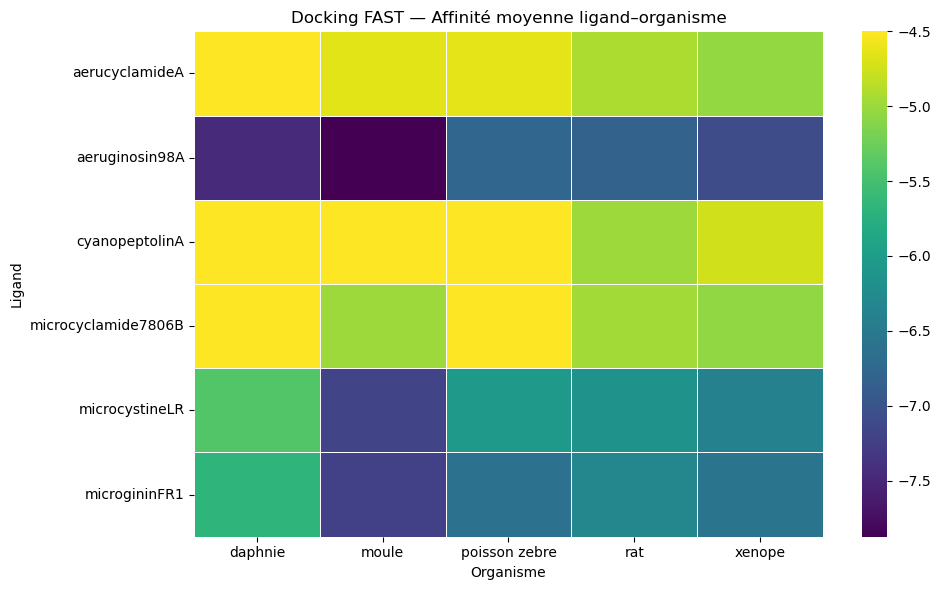

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_fast = pd.read_csv("results/summary_fast.csv")

# --- Nettoyage ligand ---
df_fast["ligand"] = (
    df_fast["ligand"]
    .astype(str)
    .str.replace(".sdf", "", regex=False)
    .str.replace("_2D", "", regex=False)
    .str.replace("_3D", "", regex=False)
)

# --- Extraction de l'organisme depuis la protéine ---
# ex : slco1d1_zebrafish -> zebrafish
df_fast["organisme"] = (
    df_fast["protein"]
    .astype(str)
    .str.lower()
    .str.replace(".pdb", "", regex=False)
    .str.split("_")
    .str[1]    # ⚠️ partie après le "_"
)

# Optionnel : renommer proprement
df_fast["organisme"] = df_fast["organisme"].replace({
    "zebrafish": "poisson zebre",
    "xenope": "xenope",
    "moule": "moule",
    "daphnia": "daphnie",
    "rattus": "rat",
    "homo": "homo"
})

# --- Pivot : moyenne des affinités par ligand × organisme ---
pivot_animals = df_fast.pivot_table(
    index="ligand",
    columns="organisme",
    values="best_affinity_kcal_mol",
    aggfunc="mean"
)

# --- Échelle couleur dynamique ---
vmin = pivot_animals.min().min()

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_animals,
    cmap="viridis",
    annot=False,
    linewidths=0.5,
    linecolor="white",
    vmin=vmin,
    vmax=-4.5
)

plt.title("Docking FAST — Affinité moyenne ligand–organisme")
plt.xlabel("Organisme")
plt.ylabel("Ligand")
plt.tight_layout()
plt.show()

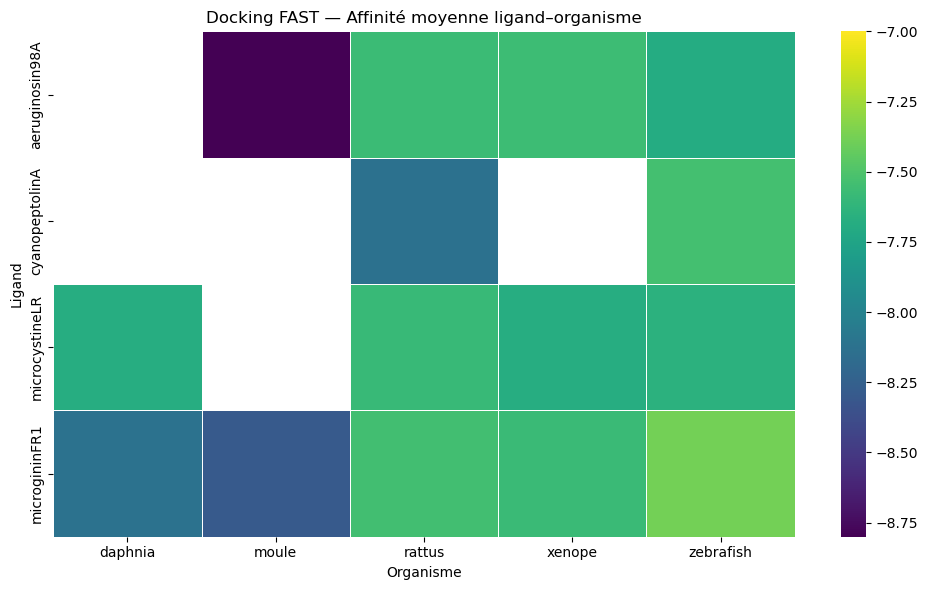

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# --- Pivot : moyenne des affinités par ligand × organisme ---
pivot_animals = df.pivot_table(
    index="ligand",
    columns="organisme",
    values="affinité",
    aggfunc="mean"
)


plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_animals,
    cmap="viridis",
    annot=False,
    linewidths=0.5,
    linecolor="white",
    vmin=-7,
    vmax=-8
)

plt.title("Docking FAST — Affinité moyenne ligand–organisme")
plt.xlabel("Organisme")
plt.ylabel("Ligand")
plt.tight_layout()
plt.show()